In [123]:
# 21 Oct 2018
#
# plot out some eddy fluxes according to ** zonal ** modal decomposition

from pydra_misc import read_qq, layers_to_modes
from pydra_analysis import *
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

from casl import parameters, spectral, constants

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["mathtext.rm"] = "serif"
plt.rcParams["image.cmap"] = "RdBu_r" # "*_r" is reverse of standard colour
plt.rcParams["axes.formatter.limits"] = [-3, 3]

In [28]:
kt = 650

data_dir = "/home/julian/data/hydra_data/jet/nx128ny64hb0.50kd20.0bdpi0.8w0.50r001/"
#data_dir = "/home/mak/data/hydra_data/jet/nx128ny64hb0.50kd20.0bdpi0.8w0.50r001/"

t_now, qq = read_qq(data_dir, parameters.nx, parameters.ny, kt, num_frame = True)

# swap axis to have the indexing consistent with the Fortran code main_invert
qq = np.swapaxes(qq, 0, 1)

# no topography
fhb = np.zeros((parameters.ny + 1, parameters.nx))

x_vec = np.linspace(0, parameters.ellx, parameters.nx, endpoint = False)
y_vec = np.linspace(-parameters.elly / 2, parameters.elly / 2, parameters.ny + 1)

uu, vv, pp = spectral.main_invert(qq, fhb)

u_bt, u_bc = layers_to_modes(uu[:, :, 0], uu[:, :, 1], constants)
v_bt, v_bc = layers_to_modes(vv[:, :, 0], vv[:, :, 1], constants)
q_bt, q_bc = layers_to_modes(qq[:, :, 0], qq[:, :, 1], constants)

number of frames found = 751 


In [164]:
vq_bt = np.zeros((parameters.ny + 1, 751))
uv_bt = np.zeros((parameters.ny + 1, 751))
for kt in range(751):
    if kt % 100 == 0:
        print("kt = %g" % kt)
    t_now, qq = read_qq(data_dir, parameters.nx, parameters.ny, kt)
    qq = np.swapaxes(qq, 0, 1)
    uu, vv, pp = spectral.main_invert(qq, fhb)

    u_bt, u_bc = layers_to_modes(uu[:, :, 0], uu[:, :, 1], constants)
    v_bt, v_bc = layers_to_modes(vv[:, :, 0], vv[:, :, 1], constants)
    q_bt, q_bc = layers_to_modes(qq[:, :, 0], qq[:, :, 1], constants)
    u_eddy = u_bt - zonal_mode_extract(u_bt, 0)
    v_eddy = v_bt - zonal_mode_extract(v_bt, 0)
    q_eddy = q_bt - zonal_mode_extract(q_bt, 0)
    vq_bt[:, kt] = np.nanmean(v_eddy * q_eddy, axis = 1)
    uv_bt[:, kt] = np.nanmean(v_eddy * u_eddy, axis = 1)



kt = 0
kt = 100
kt = 200
kt = 300
kt = 400
kt = 500
kt = 600
kt = 700


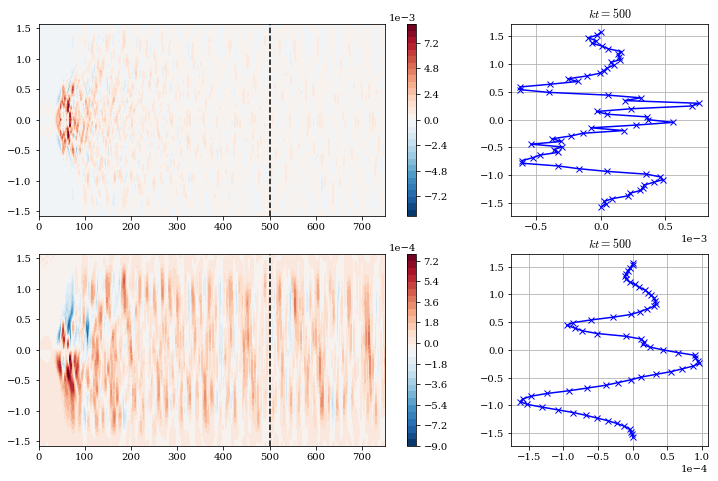

In [183]:
kt = 500
fig = plt.figure(figsize = (12, 12))

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan = 2)
mesh = ax1.contourf(np.linspace(0, 750, 751), y_vec, vq_bt, 31, cmap = "RdBu_r")
plt.plot([kt, kt], [-parameters.elly / 2, parameters.elly / 2], 'k--')
plt.colorbar(mesh)

ax2 = plt.subplot2grid((3, 3), (0, 2), colspan = 1)
ax2.plot(vq_bt[:, kt], y_vec, 'b-x')
ax2.set_title("$kt = %g$" % kt)
ax2.grid()

ax3 = plt.subplot2grid((3, 3), (1, 0), colspan = 2)
mesh = ax3.contourf(np.linspace(0, 750, 751), y_vec, uv_bt, 31, cmap = "RdBu_r")
plt.plot([kt, kt], [-parameters.elly / 2, parameters.elly / 2], 'k--')
plt.colorbar(mesh)

ax4 = plt.subplot2grid((3, 3), (1, 2), colspan = 1)
ax4.plot(uv_bt[:, kt], y_vec, 'b-x')
ax4.set_title("$kt = %g$" % kt)
ax4.grid()

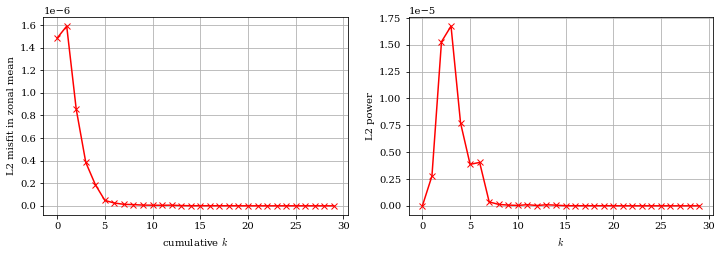

In [184]:
# vq power in modes

kt = 200
t_now, qq = read_qq(data_dir, parameters.nx, parameters.ny, kt)
qq = np.swapaxes(qq, 0, 1)
uu, vv, pp = spectral.main_invert(qq, fhb)
v_bt, v_bc = layers_to_modes(vv[:, :, 0], vv[:, :, 1], constants)
q_bt, q_bc = layers_to_modes(qq[:, :, 0], qq[:, :, 1], constants)

vq_bt_full = (v_bt - zonal_mode_extract(v_bt, 0)) * (q_bt - zonal_mode_extract(q_bt, 0))

num_modes = 30
misfit_L2 = np.zeros(num_modes)
power_L2  = np.zeros(num_modes)
for mode in range(len(misfit_L2)):
    vq_bt_mode = zonal_mode_extract(v_bt, mode, low_pass = True) * zonal_mode_extract(q_bt, mode, low_pass = True)
    misfit = (np.nanmean(vq_bt_full, axis = 1) - np.nanmean(vq_bt_mode, axis = 1)) ** 2
    misfit_L2[mode] = np.trapz(misfit, y_vec)
    
    vq_bt_mode = zonal_mode_extract(v_bt, mode) * zonal_mode_extract(q_bt, mode)
    power_L2[mode]  = np.trapz(np.trapz(vq_bt_mode ** 2, y_vec, axis = 0), x_vec)

fig = plt.figure(figsize = (12, 8))
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, num_modes, 1), misfit_L2, 'rx-')
plt.ylabel(r"L2 misfit in zonal mean")
plt.xlabel(r"cumulative $k$")
plt.grid()

ax2 = plt.subplot(2, 2, 2)
plt.plot(np.arange(0, num_modes, 1), power_L2, 'rx-')
plt.ylabel(r"L2 power")
plt.xlabel(r"$k$")
plt.grid()

So it looks like the zonal modal power is largely in the most unstable mode first ($t \leq 50$; check with $t = 35$ for example), then gradually moves into the lower modes ($50 < t \leq 90$ or thereabouts), then goes into the low modes.

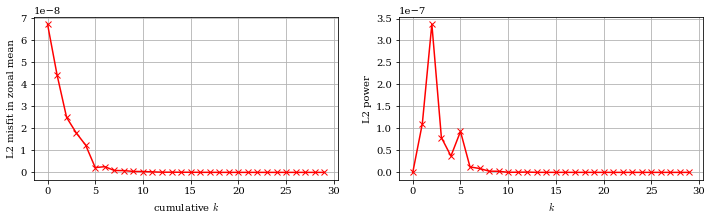

In [162]:
# uv power in modes

kt = 150
t_now, qq = read_qq(data_dir, parameters.nx, parameters.ny, kt)
qq = np.swapaxes(qq, 0, 1)
uu, vv, pp = spectral.main_invert(qq, fhb)
v_bt, v_bc = layers_to_modes(vv[:, :, 0], vv[:, :, 1], constants)
u_bt, u_bc = layers_to_modes(uu[:, :, 0], uu[:, :, 1], constants)

uv_bt_full = (v_bt - zonal_mode_extract(v_bt, 0)) * (u_bt - zonal_mode_extract(u_bt, 0))

num_modes = 30
misfit_L2 = np.zeros(num_modes)
power_L2  = np.zeros(num_modes)
for mode in range(len(misfit_L2)):
    uv_bt_mode = zonal_mode_extract(v_bt, mode, low_pass = True) * zonal_mode_extract(u_bt, mode, low_pass = True)
    misfit = (np.nanmean(uv_bt_full, axis = 1) - np.nanmean(uv_bt_mode, axis = 1)) ** 2
    misfit_L2[mode] = np.trapz(misfit, y_vec)
    
    uv_bt_mode = zonal_mode_extract(v_bt, mode) * zonal_mode_extract(u_bt, mode)
    power_L2[mode]  = np.trapz(np.trapz(uv_bt_mode ** 2, y_vec, axis = 0), x_vec)

fig = plt.figure(figsize = (12, 3))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, num_modes, 1), misfit_L2, 'rx-')
plt.ylabel(r"L2 misfit in zonal mean")
plt.xlabel(r"cumulative $k$")
plt.grid()

ax2 = plt.subplot(1, 2, 2)
plt.plot(np.arange(0, num_modes, 1), power_L2, 'rx-')
plt.ylabel(r"L2 power")
plt.xlabel(r"$k$")
plt.grid()

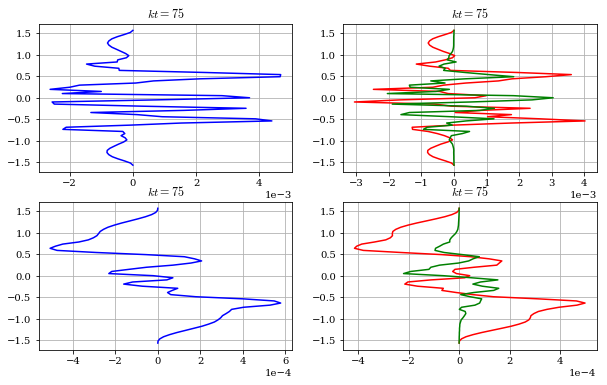

In [198]:
kt = 75

t_now, qq = read_qq(data_dir, parameters.nx, parameters.ny, kt)
qq = np.swapaxes(qq, 0, 1)
uu, vv, pp = spectral.main_invert(qq, fhb)
v_bt, v_bc = layers_to_modes(vv[:, :, 0], vv[:, :, 1], constants)
u_bt, u_bc = layers_to_modes(uu[:, :, 0], uu[:, :, 1], constants)
q_bt, q_bc = layers_to_modes(qq[:, :, 0], qq[:, :, 1], constants)

mode = 5
vq_lpass = np.nanmean(
    zonal_mode_extract(v_bt, mode, low_pass = True) * zonal_mode_extract(q_bt, mode, low_pass = True),
    axis = 1)
vq_hpass = vq_bt[:, kt] - vq_lpass
uv_lpass = np.nanmean(
    zonal_mode_extract(v_bt, mode, low_pass = True) * zonal_mode_extract(u_bt, mode, low_pass = True),
    axis = 1)
uv_hpass = uv_bt[:, kt] - uv_lpass

fig = plt.figure(figsize= (10, 6))
plt.subplot(2, 2, 1)
plt.plot(vq_bt[:, kt], y_vec, 'b-')
plt.title("$kt = %g$" % kt)
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(vq_lpass, y_vec, 'r-')
plt.plot(vq_hpass, y_vec, 'g-')
plt.title("$kt = %g$" % kt)
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(uv_bt[:, kt], y_vec, 'b-')
plt.title("$kt = %g$" % kt)
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(uv_lpass, y_vec, 'r-')
plt.plot(uv_hpass, y_vec, 'g-')
plt.title("$kt = %g$" % kt)
plt.grid()

## IDEA: if the whole signal is 1, then work out a "power" partition as a function of wavenumber
#        hypothesis being that the dominant wavenumber above which most power is in decreases
#        as the dynamics go on (i.e. all the power goes to large scales)

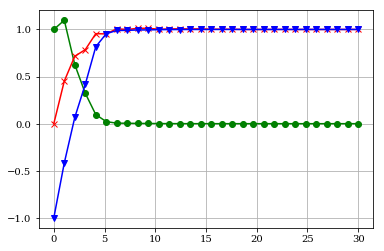

In [244]:
kt = 400

t_now, qq = read_qq(data_dir, parameters.nx, parameters.ny, kt)
qq = np.swapaxes(qq, 0, 1)
uu, vv, pp = spectral.main_invert(qq, fhb)
v_bt, v_bc = layers_to_modes(vv[:, :, 0], vv[:, :, 1], constants)
u_bt, u_bc = layers_to_modes(uu[:, :, 0], uu[:, :, 1], constants)
q_bt, q_bc = layers_to_modes(qq[:, :, 0], qq[:, :, 1], constants)

num_modes = 30
lpass_power = np.zeros(num_modes)
hpass_power = np.zeros(num_modes)
rel_power = np.zeros(num_modes)
full_power = np.trapz(vq_bt[:, kt] ** 2, y_vec)

for mode in range(num_modes):
    vq_lpass = np.nanmean(
        zonal_mode_extract(v_bt, mode, low_pass = True) * zonal_mode_extract(q_bt, mode, low_pass = True),
        axis = 1)
    vq_hpass = vq_bt[:, kt] - vq_lpass
    lpass_power[mode] = np.trapz(vq_lpass ** 2, y_vec)
    hpass_power[mode] = np.trapz(vq_hpass ** 2, y_vec)
plt.plot(np.linspace(0, num_modes, num_modes), hpass_power / full_power, 'go-')
plt.plot(np.linspace(0, num_modes, num_modes), lpass_power / full_power, 'r-x')
rel_power = (lpass_power - hpass_power) / (lpass_power + hpass_power)
plt.plot(np.linspace(0, num_modes, num_modes), rel_power, 'b-v')
plt.grid()

In [245]:
rel_power > 0.9

array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])